# Introduction to Time Series Forecasting with Statistical Models

## Setup and Imports

In [1]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Forecasting utilities
from utilsforecast.plotting import plot_series
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import *

# Keep notebook output clean
import warnings
warnings.filterwarnings("ignore")


## Data Loadin

In [2]:
# Load daily sales data
# Note: update the path if you move this project.
df = pd.read_csv('/home/musa/Desktop/Learn_forcast/data/daily_sales_french_bakery.csv', parse_dates=['ds'])

# Keep only products with at least 4 weeks of data
df = df.groupby('unique_id').filter(lambda x: len(x) >= 28)

# Drop price column to focus on demand (y)
df = df.drop(["unit_price"], axis=1)

df.head()


,unique_id,ds,y
0,12 MACARON,2022-07-13,10.0
1,12 MACARON,2022-07-14,0.0
2,12 MACARON,2022-07-15,0.0
3,12 MACARON,2022-07-16,10.0
4,12 MACARON,2022-07-17,30.0


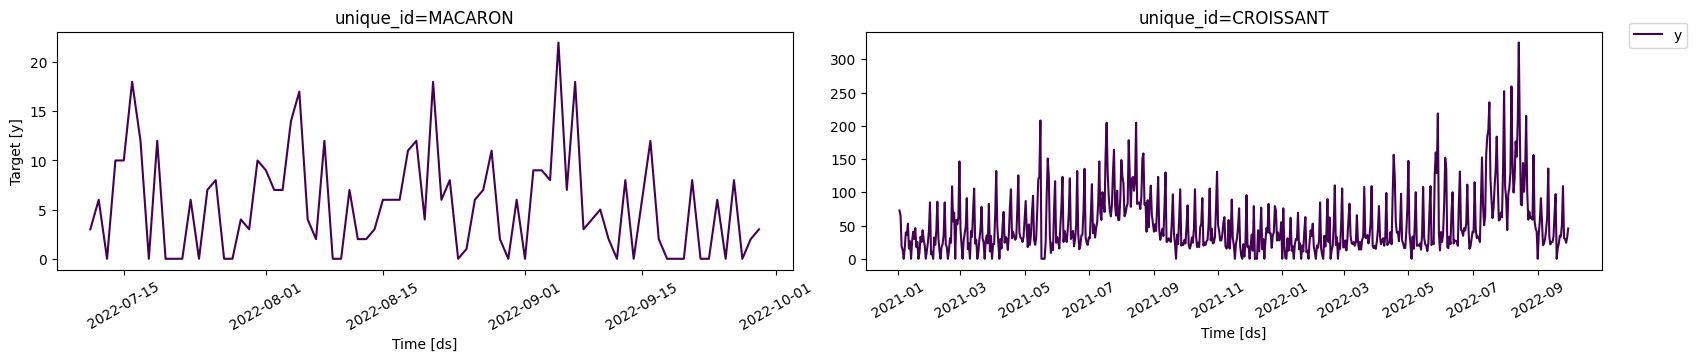

In [3]:
# Compare two products across the full history
plot_series(df=df, ids=["MACARON", "CROISSANT"], palette="viridis")


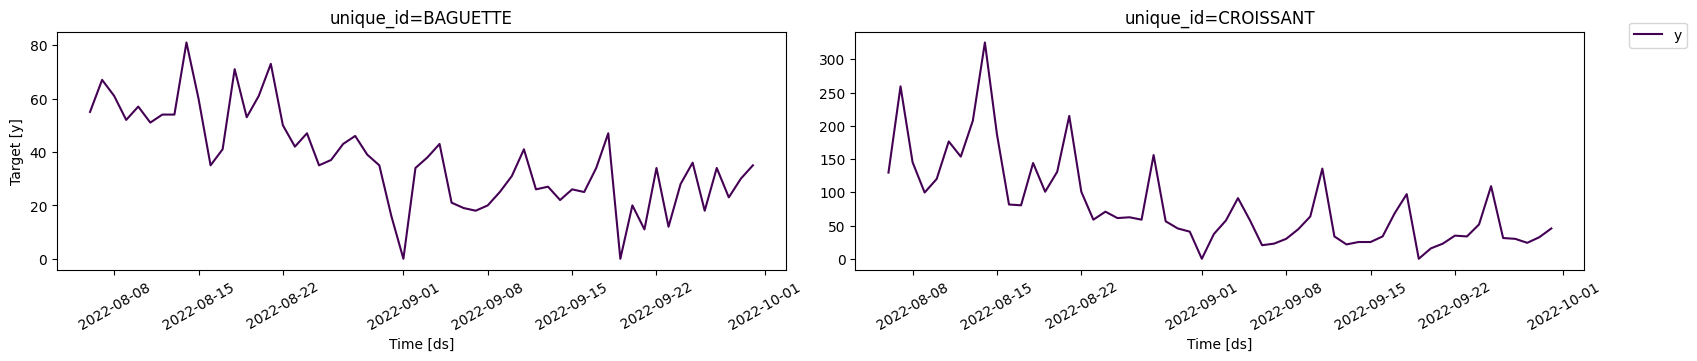

In [4]:
# Zoom into the last 8 weeks to see recent behavior
plot_series(df=df, ids=["BAGUETTE", "CROISSANT"], max_insample_length=56, palette="viridis")


## Baseline Models

In [5]:
# Simple statistical baselines
from statsforecast import StatsForecast
from statsforecast.models import Naive, HistoricAverage, WindowAverage, SeasonalNaive


In [6]:
# Forecast 7 days ahead
horizon = 7

models = [
    Naive(),
    HistoricAverage(),
    WindowAverage(window_size=7),
    SeasonalNaive(season_length=7)
]

sf = StatsForecast(models=models, freq="D")
sf.fit(df=df)
preds = sf.predict(h=horizon)


In [7]:
# Preview forecast output format
preds.head()


,unique_id,ds,Naive,HistoricAverage,WindowAverage,SeasonalNaive
0,12 MACARON,2022-09-29,10.0,8.974359,2.857143,0.0
1,12 MACARON,2022-09-30,10.0,8.974359,2.857143,0.0
2,12 MACARON,2022-10-01,10.0,8.974359,2.857143,10.0
3,12 MACARON,2022-10-02,10.0,8.974359,2.857143,0.0
4,12 MACARON,2022-10-03,10.0,8.974359,2.857143,0.0


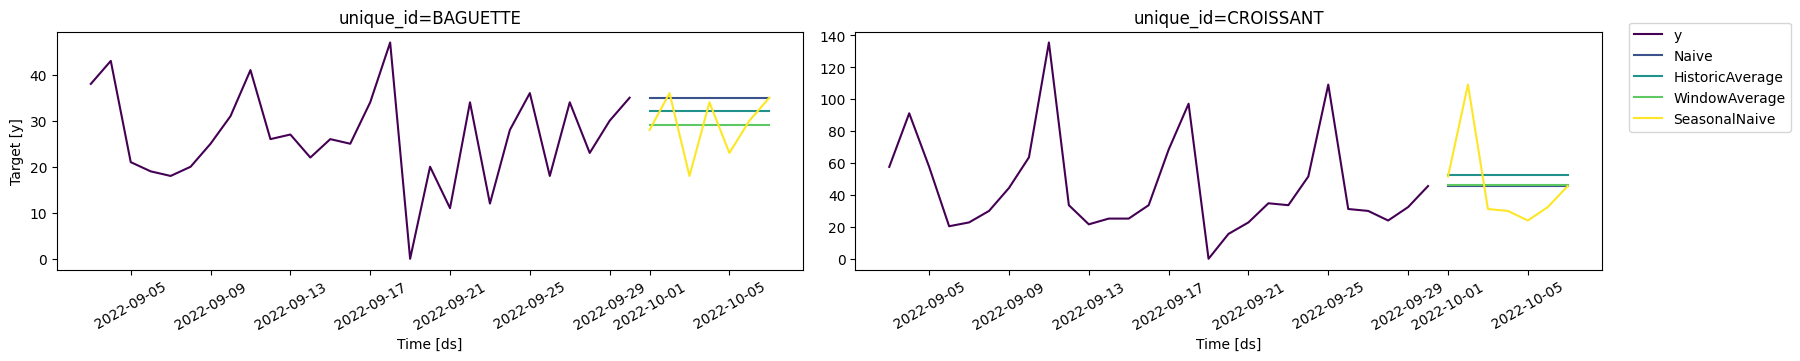

In [8]:
# Plot baseline forecasts alongside history
plot_series(
    df=df, 
    forecasts_df=preds, 
    ids=["BAGUETTE", "CROISSANT"], 
    max_insample_length=28, 
    palette="viridis")


## Train/Test Split and Evaluation


In [9]:
# Hold out the last 7 days per product for testing
test = df.groupby('unique_id').tail(7)
train = df.drop(test.index).reset_index(drop=True)


In [10]:
# Refit on training data and align predictions with test set
sf.fit(df=train)

preds = sf.predict(h=horizon)

eval_df = pd.merge(test, preds, 'left', ['ds', "unique_id"])


### Evaluate Baseline Models


In [11]:
# Compute MAE for each method
evaluation = evaluate(
    df=eval_df, 
    metrics=[mae],
)
evaluation.head()


,unique_id,metric,Naive,HistoricAverage,WindowAverage,SeasonalNaive
0,12 MACARON,mae,2.857143,6.961771,3.469388,4.285714
1,BAGUETTE,mae,17.142857,5.455193,7.877551,12.571429
2,BAGUETTE APERO,mae,0.000000,0.537572,0.642857,0.642857
3,BAGUETTE GRAINE,mae,9.800000,4.612271,2.942857,0.200000
4,BANETTE,mae,1.314286,5.421984,6.008163,7.885714


In [12]:
# Average MAE across products
evaluation = evaluation.drop(['unique_id'], axis=1).groupby('metric').mean().reset_index()
evaluation


,metric,Naive,HistoricAverage,WindowAverage,SeasonalNaive
0,mae,6.107556,5.228439,5.011663,4.613636


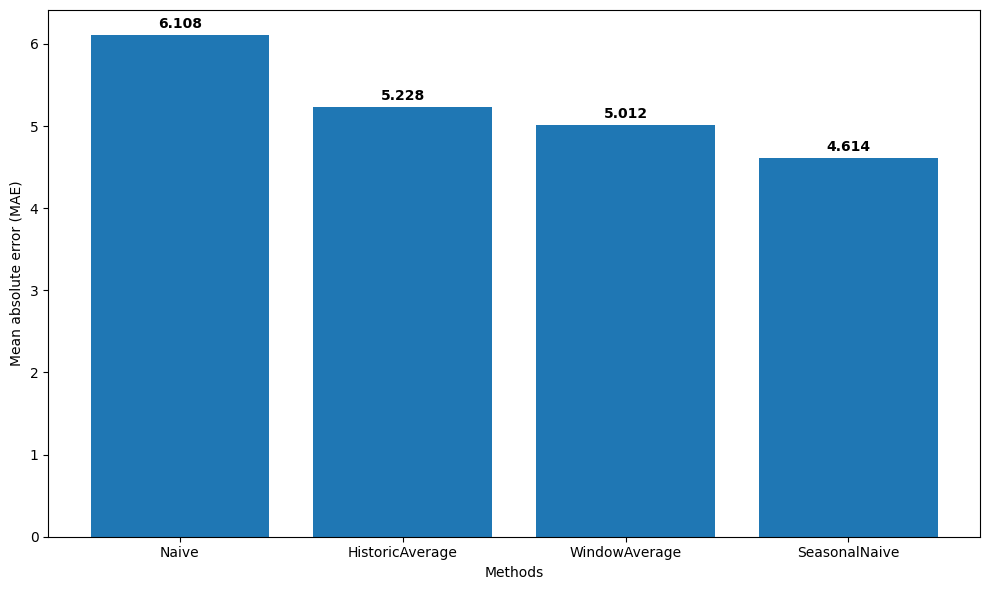

In [13]:
# Visualize baseline errors
methods = evaluation.columns[1:].tolist()  
values = evaluation.iloc[0, 1:].tolist() 

plt.figure(figsize=(10, 6))
bars = plt.bar(methods, values)

for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05, 
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

plt.xlabel('Methods')
plt.ylabel('Mean absolute error (MAE)')
plt.tight_layout()

plt.show()


## ARIMA Models (AutoARIMA)

In [14]:
# Automatic ARIMA model selection
from statsforecast.models import AutoARIMA
# Use two example products for faster ARIMA training
unique_ids = ["BAGUETTE", "CROISSANT"]

small_train = train[train["unique_id"].isin(unique_ids)]
small_test = test[test["unique_id"].isin(unique_ids)]

models = [
    AutoARIMA(seasonal=False, alias="ARIMA"),
    AutoARIMA(season_length=7, alias="SARIMA")
]

sf = StatsForecast(models=models, freq="D")
sf.fit(df=small_train)
arima_preds = sf.predict(h=horizon)

arima_eval_df = pd.merge(arima_preds, eval_df, 'inner', ['ds', 'unique_id'])
arima_eval = evaluate(
    arima_eval_df,
    metrics=[mae],
)
arima_eval


,unique_id,metric,ARIMA,SARIMA,Naive,HistoricAverage,WindowAverage,SeasonalNaive
0,BAGUETTE,mae,9.353153,7.449083,17.142857,5.455193,7.877551,12.571429
1,CROISSANT,mae,14.565395,10.359143,17.485714,22.618934,18.244898,12.857143


In [15]:
# Average MAE across the selected products
arima_eval = arima_eval.drop(['unique_id'], axis=1).groupby('metric').mean().reset_index()
arima_eval


,metric,ARIMA,SARIMA,Naive,HistoricAverage,WindowAverage,SeasonalNaive
0,mae,11.959274,8.904113,17.314286,14.037063,13.061224,12.714286


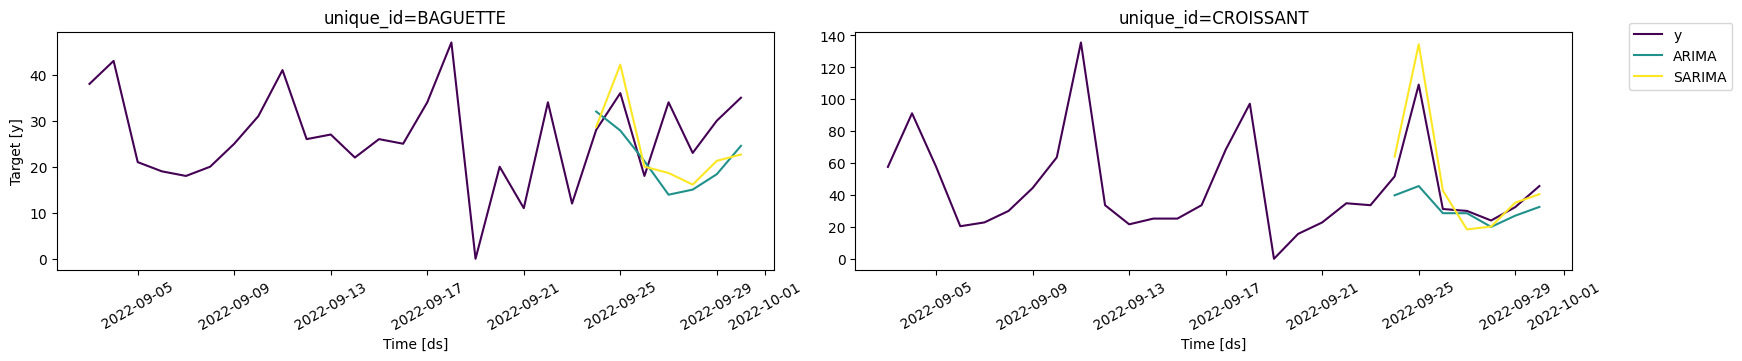

In [16]:
# Plot ARIMA forecasts
plot_series(
    df=df, 
    forecasts_df=arima_preds, 
    ids=["BAGUETTE", "CROISSANT"], 
    max_insample_length=28, 
    palette="viridis")


### Why SARIMA Often Wins

SARIMA captures multiple patterns at once:

1. Short-term autocorrelation (recent days matter)
2. Trend (level changes over time)
3. Weekly seasonality (day-of-week effects)

Most simpler baselines miss at least one of these.


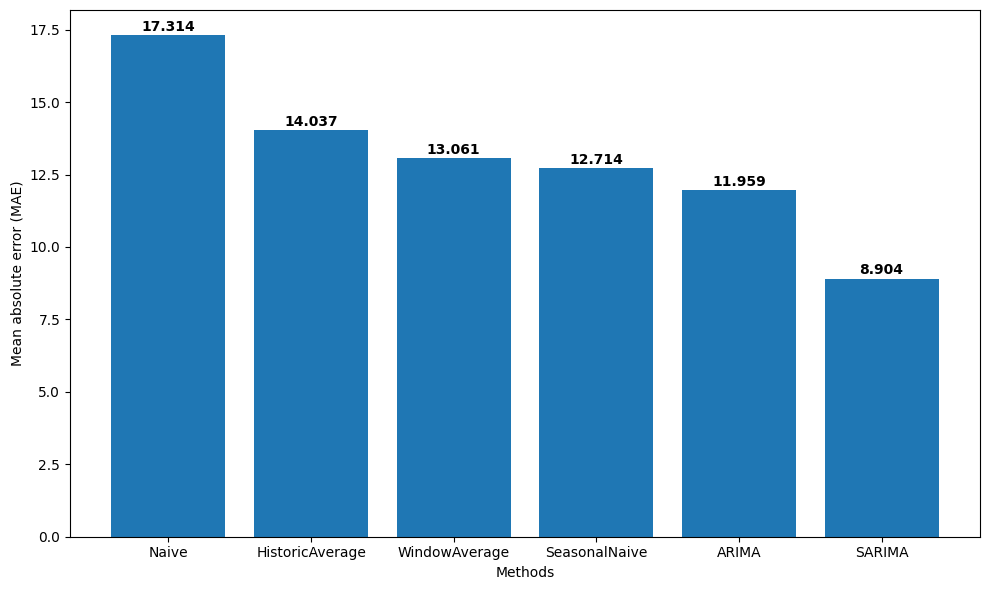

In [17]:
# Compare ARIMA variants by MAE
methods = arima_eval.columns[1:].tolist()  
values = arima_eval.iloc[0, 1:].tolist() 

sorted_data = sorted(zip(methods, values), key=lambda x: x[1], reverse=True)
methods_sorted, values_sorted = zip(*sorted_data)

plt.figure(figsize=(10, 6))
bars = plt.bar(methods_sorted, values_sorted)

for bar, value in zip(bars, values_sorted):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05, 
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

plt.xlabel('Methods')
plt.ylabel('Mean absolute error (MAE)')
plt.tight_layout()

plt.show()


## Rolling Cross-Validation

In [ ]:
# Rolling origin evaluation for more robust performance estimates
small_df = df[df["unique_id"].isin(unique_ids)]

models = [
    SeasonalNaive(season_length=7),
    AutoARIMA(seasonal=False, alias="ARIMA"),
    AutoARIMA(season_length=7, alias="SARIMA")
]

sf = StatsForecast(models=models, freq="D")
cv_df = sf.cross_validation(
    h=horizon, # 7 days
    df=small_df,
    n_windows=8,
    step_size=horizon,
    refit=True
)

cv_df.head()


In [ ]:
# Visualize rolling forecasts across multiple cutoffs
plot_series(
    df=small_df, 
    forecasts_df=cv_df.drop(["y", "cutoff"], axis=1), 
    ids=["BAGUETTE", "CROISSANT"], 
    max_insample_length=140, 
    palette="viridis")


In [ ]:
# Evaluate MAE across all CV windows
cv_eval = evaluate(
    cv_df.drop(["cutoff"], axis=1),
    metrics=[mae],
)
cv_eval = cv_eval.drop(['unique_id'], axis=1).groupby('metric').mean().reset_index()
cv_eval


In [ ]:
# Compare CV performance by method
methods = cv_eval.columns[1:].tolist()  
values = cv_eval.iloc[0, 1:].tolist() 

sorted_data = sorted(zip(methods, values), key=lambda x: x[1], reverse=True)
methods_sorted, values_sorted = zip(*sorted_data)

plt.figure(figsize=(10, 6))
bars = plt.bar(methods_sorted, values_sorted)

for bar, value in zip(bars, values_sorted):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05, 
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

plt.xlabel('Methods')
plt.ylabel('Mean absolute error (MAE)')
plt.tight_layout()

plt.show()
